The Demon Algorithm
===========

There are a number of approaches to complex problems involving large numbers of interactions where the objective is to find the "average" behavior of the system over a long period of time. We've seen that we can integrage Newton's 2nd Law to see the precise behavior of a multipartical system over time. When we have a handful of objects in a system this works well. However, if we have thousands or millions of particles, it's not practical. Looking at "average" behavior however glosses over the precision of following each interaction and attempts only to see what happens on a less fine-grained scale. This means we sacrifice the hope of getting a detailed pictured of a microscopic physical process, but achieve the reward of a more general understanding of the large scale consequences of that process. The demon algorithm is such an approach. It's a simple way to simulate the random exchange of energy between components of a system over time. Here's the basic idea:

* Suppose we have a demon..

    1 Make a small change to the system.

    2 Compute $\Delta E$. If $\Delta E<0$ give it to the “demon” and accept the change.

    3 If $\Delta E>0$ and the demon has that much energy available, accept the change and take the energy from the demon.
    
    4 If the demon doesn’t have that much energy, then reject the change.
    
Example Problem
---------------

Compute the height distribution of nitrogen molecules near the Earth's surface. Assume T=const. and that the weight of a molecule is constant.

$$ PE(y) = m g y $$

so $\Delta E$ is just $m g \Delta y$.

Below is a sample program that uses the demon algorithm to approach this problem.

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


0.9476828824145266
(array([  13.,   47.,  123.,  215.,  232.,  192.,  119.,   39.,   15.,    5.]), array([-2.7374974 , -2.12548311, -1.51346882, -0.90145453, -0.28944024,
        0.32257405,  0.93458834,  1.54660263,  2.15861692,  2.77063121,
        3.3826455 ]), <a list of 10 Patch objects>)


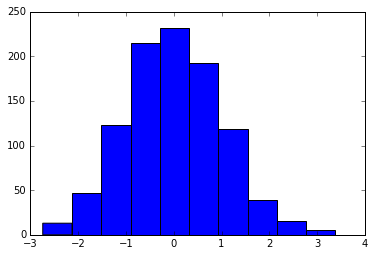

In [6]:
#
# rand() returns a single random number:
#

print(rand())

#
# hist plots a histogram of an array of numbers
#

print(hist(normal(size=1000)))

(array([ 100.,   89.,   88.,   90.,  123.,   96.,  104.,  107.,  103.,  100.]),
 array([  4.44630797e-04,   2.00310731e-01,   4.00176830e-01,
          6.00042930e-01,   7.99909030e-01,   9.99775130e-01,
          1.19964123e+00,   1.39950733e+00,   1.59937343e+00,
          1.79923953e+00,   1.99910563e+00]),
 <a list of 10 Patch objects>)

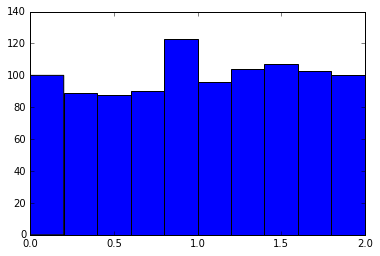

In [7]:
m=28*1.67e-27  # mass of a molecule (e.g., Nitrogen)
g=9.8          # grav field strength
kb=1.67e-23    # boltzman constant
demonE = 0.0   # initial demon energy
N=10000        # number of molecules
M=400000       # number of iterations
h=20000.0      # height scale

def setup(N=100,L=1.0):
    y=L*rand(N)     # put N particles at random heights (y) between 0 and L
    return y

yarray = setup(N=1000,L=2.0)
hist(yarray)


77.10225 percent accepted
Averge height=9973.304m


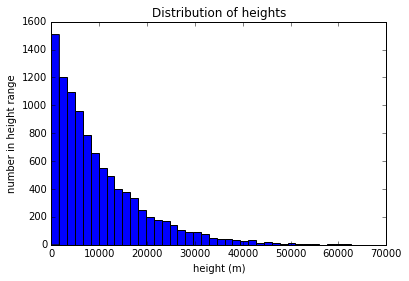

In [9]:
def shake(y, demonE, delta=0.1):
    """
    Pass in the current demon energy as an argument.
    delta is the size of change in y to generate, more or less.
    randomly choose a particle, change it's position slightly (around delta)
    return the new demon energy and a boolean (was the change accepted?)
    """
    ix = int(rand()*len(y))
    deltaY = delta*normal()
    deltaE = deltaY*m*g
    accept=False
    if deltaE < demonE and (y[ix]+deltaY>0):
        demonE -= deltaE  # take the energy from the demon, or give it if deltaE<0.
        y[ix] += deltaY
        accept=True
        
    return demonE, accept

y = setup(N,L=h)

acceptCount = 0

demonList = []
for i in range(M):
    demonE,accept = shake(y, demonE, delta=0.2*h)
    demonList.append(demonE)
    if accept:
        acceptCount += 1

title("Distribution of heights")
xlabel("height (m)")
ylabel("number in height range")
hist(y,bins=40)
print(100.0*acceptCount/M, "percent accepted")
print("Averge height=%4.3fm" % (y.sum()/len(y),))

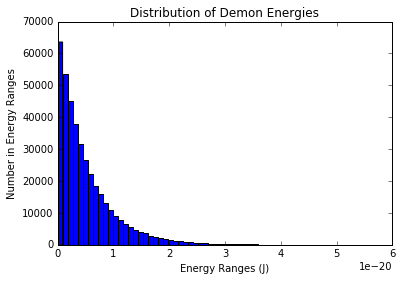

In [10]:
#
# Build a histogram of Demon Energies
#

title("Distribution of Demon Energies")
xlabel("Energy Ranges (J)")
ylabel("Number in Energy Ranges")
ns, bins, patches = hist(demonList, bins=60)

Demonic Thermometer
====================

You can easily see that the demon acts like an small thermometer. According to the Maxwell-Boltzmann distribution the energy distribution of the demon's energy should go like:

$$P(E) = P_0 e^{-E/k_B T}$$

Where $P_0$ is the basically the probability of having an energy of zero. (Actually, maybe a better way to think of it is as a normalization constant that's determined by the requirement that the total probability to have *any* energy is 1.0). The histogram of demon energies tells us the number of times the demon have various values of energy during the calculation. This is proportional to the probability that the demon had various energies. We can fit that probability to an exponential curve (or the log of the probability to a straight line) and from the slope of the line deduce the temperature!

See below how the code does exactly this.


slope= -1.90714037137e+20 +/- 6.16514763062e+17
intercept= 11.1373229547 +/- 0.00459800607707
Temperature= 313.979193247 +/- 1.01498982895 K


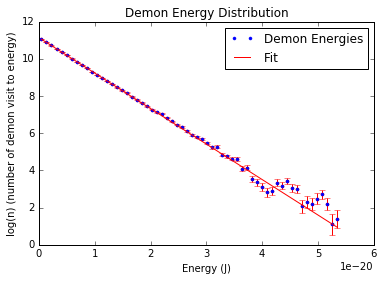

In [13]:
#
# Use a "curve fit" to find the temperature of the demon
#

from scipy.optimize import curve_fit

def fLinear(x, m, b):
    return m*x + b

energies = (bins[:-1]+bins[1:])/2.0
xvals = array(energies)  # fit log(n) vs. energy
yvals = log(array(ns))
sig = 1.0/sqrt(array(ns))

#
# make initial estimates of slope and intercept.
#

m0 = (yvals[-1]-yvals[0])/(xvals[-1]-xvals[0])
b0 = yvals[0]-m0*xvals[0]

popt, pcov = curve_fit(fLinear, xvals, yvals, p0=(m0, b0), sigma=sig)

m=popt[0]          # slope
dm=sqrt(pcov[0,0]) # sqrt(variance(slope))
b=popt[1]          # int
db=sqrt(pcov[1,1]) # sqrt(variance(int))
Temp=-1.0/(m*kb)   # temperature
dT = abs(dm*Temp/m)# approx uncertainty in temp

print("slope=", m, "+/-", dm )
print("intercept=", b, "+/-", db)
print("Temperature=", Temp, "+/-", dT, "K")
title("Demon Energy Distribution")
xlabel("Energy (J)")
ylabel("log(n) (number of demon visit to energy)")
errorbar(xvals, yvals, sig, fmt='r.')
plot(xvals,yvals,'b.',label="Demon Energies")
plot(xvals,fLinear(xvals, m, b),'r-', label="Fit")
legend()

Proj 5: (option 1) 
==========

Velocity distribution in a 1-D gas
--------------------------------

For project 5 use the above example as a starting point to investigate the distribution of velocities of nitrogen molecules in a 1D gas. Start the velocities out in some random distribution, then each 'step' should bump one molecule up or down in velocity randomly. Use the demon algorithm to exchange energy between the system and the demon. Use the same strategy to show a final distribution of velocities and energies to determine the  temperature of the system.

Proj 5: (option 2) 
==========

Monte-Carlo Simulation
---------------------

The main point of this project is to use the generation of random data to answer non-trivial questions. If you don't love the idea of the velocity distribution of particles in a gas, you can attack any problem you care to dream up that could be modeled using a large number of random numbers in some way. If you choose to do this, please let me know your plans!


